## 자전거 대여 수요 예측

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('train_bike.csv')
print(bike_df.shape)
bike_df.head(5)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df['datetime'] = bike_df['datetime'].str.replace('-', ' ')
bike_df['datetime'] = bike_df['datetime'].str.replace(':', ' ')
bike_df[['year', 'month', 'day', 'hour', 'minute', 'second']] = bike_df['datetime'].str.split(' ', expand=True)
bike_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011 01 01 00 00 00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,01,01,00,00,00
1,2011 01 01 01 00 00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,01,01,01,00,00
2,2011 01 01 02 00 00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,01,01,02,00,00
3,2011 01 01 03 00 00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,01,01,03,00,00
4,2011 01 01 04 00 00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,01,01,04,00,00


In [3]:
date_columns = ['year', 'month', 'day', 'hour', 'minute', 'second']
cols_to_drop = ['minute', 'second', 'hour', 'day']
cols_not_drop = [item for item in date_columns if item not in cols_to_drop]

bike_df.drop(columns = ['datetime'] + cols_to_drop, inplace = True)
bike_df[cols_not_drop] = bike_df[cols_not_drop].apply(pd.to_numeric, errors='coerce')

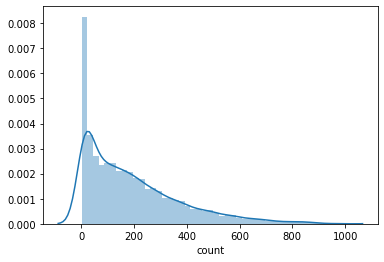

In [4]:
import seaborn as sns

sns.distplot(bike_df['count'])

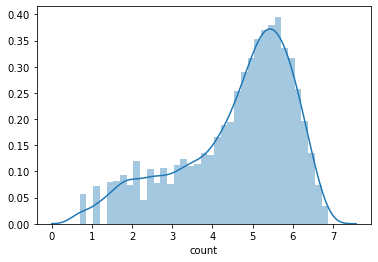

In [5]:
#count의 값 스케일링

bike_df['count'] = np.log1p(bike_df['count'])
sns.distplot(bike_df['count'])

In [6]:
from sklearn.preprocessing import StandardScaler

def scaleDf(input_df, columns):
    df = input_df.copy()
    scaler = StandardScaler()
    df[columns] = scaler.fit_transform(df[columns])
    return df

In [7]:
scaled_df = scaleDf(bike_df, ['temp', 'atemp', 'humidity', 'casual', 'registered'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025E348DB700>,
      dtype=object)

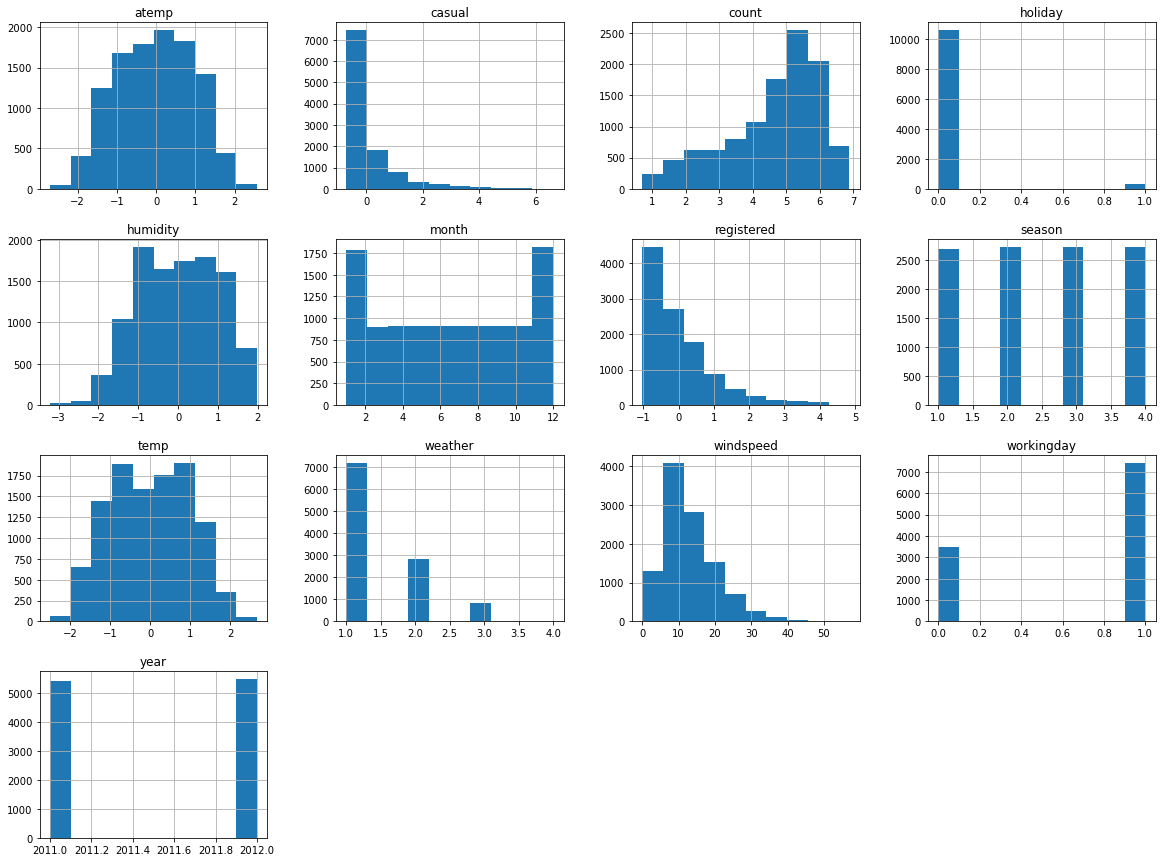

In [8]:
scaled_df.hist(figsize=(20, 15))

In [9]:
# season, weather를 one-hot encoding한다.

def oneHotDf(df):
    bike_oh = df.copy()
    bike_oh['weather_1'], bike_oh['weather_2'], bike_oh['weather_3'], bike_oh['weather_4'] = 0, 0, 0, 0
    bike_oh.loc[bike_oh['weather'] == 1, 'weather_1'] = 1
    bike_oh.loc[bike_oh['weather'] == 2, 'weather_2'] = 1
    bike_oh.loc[bike_oh['weather'] == 3, 'weather_3'] = 1
    bike_oh.loc[bike_oh['weather'] == 4, 'weather_4'] = 1
    bike_oh.drop(columns = ['weather'], inplace=True)

    bike_oh['season_1'], bike_oh['season_2'], bike_oh['season_3'], bike_oh['season_4'] = 0, 0, 0, 0
    bike_oh.loc[bike_oh['season'] == 1, 'season_1'] = 1
    bike_oh.loc[bike_oh['season'] == 2, 'season_2'] = 1
    bike_oh.loc[bike_oh['season'] == 3, 'season_3'] = 1
    bike_oh.loc[bike_oh['season'] == 4, 'season_4'] = 1
    bike_oh.drop(columns = ['season'], inplace=True)
    
    return bike_oh

In [10]:
# scaled_df.drop(columns=['registered', 'casual'], inplace=True)
# 위를 시도해봤는데 성능이 더 안좋아짐

onehot_df = oneHotDf(scaled_df)

In [11]:
def moveCountToEnd(df):
    df = df[[c for c in df if c not in ['count']] + ['count']]
    return df

onehot_df = moveCountToEnd(onehot_df)
scaled_df = moveCountToEnd(scaled_df)
scaled_df.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,year,month,count
0,1,0,0,1,-1.333661,-1.092737,0.993213,0.0,-0.660992,-0.943854,2011,1,2.833213
1,1,0,0,1,-1.438907,-1.182421,0.941249,0.0,-0.560908,-0.818052,2011,1,3.713572
2,1,0,0,1,-1.438907,-1.182421,0.941249,0.0,-0.620958,-0.851158,2011,1,3.496508
3,1,0,0,1,-1.333661,-1.092737,0.681430,0.0,-0.660992,-0.963717,2011,1,2.639057
4,1,0,0,1,-1.333661,-1.092737,0.681430,0.0,-0.721042,-1.023307,2011,1,0.693147


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

LinearRegression = LinearRegression()
DecisionTree = DecisionTreeRegressor(random_state=0, max_depth=6)
RandomForest = RandomForestRegressor(random_state=0, n_estimators=1000)
GradientBoost = GradientBoostingRegressor(random_state=0, n_estimators=1000)
XGB = XGBRegressor(n_estimators=1000)
LGBM = LGBMRegressor(n_estimators=1000)

models = [LinearRegression, DecisionTree, RandomForest, GradientBoost, XGB, LGBM]
models_names = ['LinearRegression', 'DecisionTree', 'RandomForest', 'GradientBoost', 'XGB', 'LGBM']

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def trainDf(typeOfDf, df, models):
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=0)
    y_test = np.exp(y_test) - 1
    
    eval_df_dict = dict()
    
    for ind in range(len(models)):
        model = models[ind]
        name = models_names[ind]
        model.fit(X_train ,y_train)
        y_preds = model.predict(X_test)
        
        y_preds = np.exp(y_preds) - 1
        
        mse = mean_squared_error(y_test, y_preds)
        rmse = np.sqrt(mse)
        
        eval_df_dict[name] = [np.round(mse, 3), np.round(rmse, 3), np.round(r2_score(y_test, y_preds), 3)]
        
        #print(f'{type(model)}')
        #print(f'{typeOfDf} MSE : {mse:.3f} , RMSE : {rmse:.3F}')
        #print(f'{typeOfDf} Variance score : {r2_score(y_test, y_preds):.3f}\n\n')
    eval_df = pd.DataFrame(eval_df_dict, index=['mse', 'rmse', 'r2'])
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(eval_df)

In [14]:
trainDf('Label Encoded', scaled_df, models)
trainDf('Onehot Encoded', onehot_df, models)

      LinearRegression  DecisionTree  RandomForest  GradientBoost    XGB  \
mse         421226.576       500.775         8.185          6.258  9.223   
rmse           649.020        22.378         2.861          2.502  3.037   
r2             -11.678         0.985         1.000          1.000  1.000   

        LGBM  
mse   10.686  
rmse   3.269  
r2     1.000  
      LinearRegression  DecisionTree  RandomForest  GradientBoost    XGB  \
mse         412242.214       500.775         8.089          5.809  8.570   
rmse           642.061        22.378         2.844          2.410  2.927   
r2             -11.407         0.985         1.000          1.000  1.000   

       LGBM  
mse   9.977  
rmse  3.159  
r2    1.000  


In [15]:
#scaling 없이 학습시도
trainDf('Not scaled : ', bike_df, models)

      LinearRegression  DecisionTree  RandomForest  GradientBoost  \
mse       1.023503e+09  6.697069e+08  4.258801e+08   5.681017e+08   
rmse      3.199223e+04  2.587870e+04  2.063686e+04   2.383488e+04   
r2        5.060000e-01  6.770000e-01  7.940000e-01   7.260000e-01   

               XGB          LGBM  
mse   5.830140e+08  5.019011e+08  
rmse  2.414568e+04  2.240315e+04  
r2    7.180000e-01  7.580000e-01  


In [16]:
# scaling을 안하면 제대로 학습이 안됨
# label encoding보다 one hot encoding이 조금 더 성능이 좋다

#month가 season과 관련성이 있다고 판단, month를 지우고 다시 학습

no_df = onehot_df.drop(columns=['month'])

trainDf('No month: ', no_df, models)

      LinearRegression  DecisionTree  RandomForest  GradientBoost    XGB  \
mse         416648.516       500.775         8.231          6.178  8.728   
rmse           645.483        22.378         2.869          2.486  2.954   
r2             -11.540         0.985         1.000          1.000  1.000   

        LGBM  
mse   10.627  
rmse   3.260  
r2     1.000  
